In [33]:
# =========================================================
# 📦 Cell 1 — Environment Setup and Global Configuration
# =========================================================

# Import basic libraries
from pathlib import Path
import sys, warnings
import numpy as np

# Set a global random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure Plotly renderer
# - "vscode" for VS Code Notebooks
# - "notebook_connected" for Jupyter
import plotly.io as pio
pio.renderers.default = "vscode"

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Print environment info for debugging
print("✅ Environment initialized")
print("Python version:", sys.version)
print("Plotly renderer:", pio.renderers.default)
print("Random seed:", RANDOM_SEED)

✅ Environment initialized
Python version: 3.14.0 (v3.14.0:ebf955df7a8, Oct  7 2025, 08:20:14) [Clang 16.0.0 (clang-1600.0.26.6)]
Plotly renderer: vscode
Random seed: 42


In [34]:
# =========================================================
# 🛠️ Cell 2 — Config Loader (YAML/JSON) with Safe Defaults
# =========================================================

from typing import Any, Dict
import json

# Try to import PyYAML. If not installed, we'll still work with JSON or defaults.
try:
    import yaml  # type: ignore
except Exception:
    yaml = None

def load_config(path: str | Path | None = None) -> Dict[str, Any]:
    """
    Load a configuration from YAML or JSON.
    Falls back to sensible defaults if the file is missing or YAML isn't installed.
    """
    # ---- Default configuration (edit these as needed) ----
    default = {
        "data": {
            # Primary location of your raw CSVs (you can change this to your local path)
            "input_dir": "/Users/dhwanil/Desktop/ONGOING PROJECTS/data for kpi",
            # Where to save the processed/cleaned dataset (used by the app later)
            "processed": "../data/processed/clean_data.csv",
        },
        "preprocess": {
            "grain": "global",         # "global" (aggregate all stores) or "store"
        },
        "models": {
            "ml": {
                "method": "isolation_forest",
                "contamination": 0.02,
                "n_estimators": 300,
                "random_state": RANDOM_SEED,
            }
        }
    }

    # If no path is provided, just return defaults
    if not path:
        return default

    p = Path(path)
    if not p.exists():
        print(f"⚠️ Config not found at {p}. Using defaults.")
        return default

    # Load YAML if available; else JSON
    if p.suffix.lower() in {".yaml", ".yml"} and yaml is not None:
        with open(p, "r", encoding="utf-8") as f:
            cfg = yaml.safe_load(f)
    elif p.suffix.lower() == ".json":
        with open(p, "r", encoding="utf-8") as f:
            cfg = json.load(f)
    else:
        print(f"⚠️ Unsupported config format for {p}. Using defaults.")
        return default

    # Shallow-merge file config over defaults
    def merge(a: dict, b: dict) -> dict:
        out = dict(a)
        for k, v in (b or {}).items():
            if isinstance(v, dict) and isinstance(out.get(k), dict):
                out[k] = merge(out[k], v)
            else:
                out[k] = v
        return out

    return merge(default, cfg or {})

# Load your config (change the path if needed)
CFG = load_config("configs/default.yaml")
print("✅ Config loaded")
print("Input dir:", CFG['data']['input_dir'])
print("Processed path:", CFG['data']['processed'])
print("Grain:", CFG['preprocess']['grain'])

⚠️ Config not found at configs/default.yaml. Using defaults.
✅ Config loaded
Input dir: /Users/dhwanil/Desktop/ONGOING PROJECTS/data for kpi
Processed path: ../data/processed/clean_data.csv
Grain: global


In [35]:
# =========================================================
# 📁 Cell 3 — Resolve Data Paths and Ensure Output Directory
# =========================================================

from pathlib import Path

# Candidate directories for raw data
CANDIDATE_DIRS = [
    Path(CFG["data"]["input_dir"]),
    Path("../data/raw"),
    Path("~/Desktop/kpi-data").expanduser(),
]

# Try to find a valid data directory
DATA_DIR = None
for p in CANDIDATE_DIRS:
    if p.exists():
        DATA_DIR = p
        break

# Show result
if DATA_DIR is None:
    print("⚠️ No valid data directory found — will use synthetic data instead.")
else:
    print("✅ Using data directory:", DATA_DIR)

# Ensure processed output folder exists
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

✅ Using data directory: /Users/dhwanil/Desktop/ONGOING PROJECTS/data for kpi


In [36]:
# =========================================================
# 🔧 Cell 4 — Core Library Imports and Setup
# =========================================================

# Data handling & math
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.ensemble import IsolationForest

# Display settings for pandas
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Quick verification
print("✅ Core libraries imported successfully")
print("pandas version:", pd.__version__)

✅ Core libraries imported successfully
pandas version: 2.3.3


In [37]:
# =========================================================
# 🧮 Cell 5 — Data Loading Functions (Local + Synthetic)
# =========================================================

def load_local_store_sales(data_dir: Path, grain: str = "global") -> pd.DataFrame:
    """
    Load the Store Sales dataset (or similar KPI data) from local CSV files.
    Args:
        data_dir : Path to the folder containing train.csv, transactions.csv, etc.
        grain : "global" to aggregate across stores, or "store" to keep each store.
    Returns:
        pd.DataFrame with merged data and cleaned columns.
    """
    # File paths
    train_fp = data_dir / "train.csv"
    trans_fp = data_dir / "transactions.csv"
    oil_fp = data_dir / "oil.csv"
    hol_fp = data_dir / "holidays_events.csv"
    stores_fp = data_dir / "stores.csv"

    # Load main training data
    use_cols = ["date", "store_nbr", "sales", "onpromotion"]
    df = pd.read_csv(train_fp, parse_dates=["date"])[use_cols]

    # Aggregate by date if working at global level
    if grain == "global":
        df = df.groupby("date", as_index=False).agg(
            sales=("sales", "sum"),
            onpromotion=("onpromotion", "sum"),
        )

    # Merge transactions
    if trans_fp.exists():
        trans = pd.read_csv(trans_fp, parse_dates=["date"])
        if grain == "global":
            trans = trans.groupby("date", as_index=False)["transactions"].sum()
            df = df.merge(trans, on="date", how="left")
        else:
            df = df.merge(trans, on=["date", "store_nbr"], how="left")

    # Merge oil prices
    if oil_fp.exists():
        oil = pd.read_csv(oil_fp, parse_dates=["date"]).rename(columns={"dcoilwtico": "oil_price"})
        oil = oil.sort_values("date").set_index("date").ffill().reset_index()
        df = df.merge(oil, on="date", how="left")

    # Merge holidays
    if hol_fp.exists():
        hol = pd.read_csv(hol_fp, parse_dates=["date"])
        hol = hol[hol["transferred"] == False].copy()
        hol["is_holiday"] = 1
        hol = hol.groupby("date", as_index=False)["is_holiday"].max()
        df = df.merge(hol, on="date", how="left")
        df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)

    # Forward-fill missing values
    for col in ["transactions", "oil_price"]:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()

    # Sort by date
    return df.sort_values("date").reset_index(drop=True)


def make_synthetic(days: int = 730, seed: int = RANDOM_SEED) -> pd.DataFrame:
    """
    Generate a synthetic KPI dataset for testing or demo.
    Produces daily sales, revenue, cost, and engagement with injected anomalies.
    """
    rng = np.random.default_rng(seed)
    dates = pd.date_range("2021-01-01", periods=days)

    sales = 200 + np.sin(np.linspace(0, 15, days)) * 20 + rng.normal(0, 5, days)
    revenue = sales * (10 + rng.normal(0, 0.5, days))
    cost = revenue * rng.uniform(0.6, 0.8, days)
    engagement = rng.normal(100, 10, days)
    oil_price = 60 + np.sin(np.linspace(0, 30, days)) * 5 + rng.normal(0, 1, days)

    # Inject a few random anomalies
    anomaly_idx = rng.choice(len(dates), 12, replace=False)
    sales[anomaly_idx] *= rng.uniform(0.5, 1.6, len(anomaly_idx))

    return pd.DataFrame({
        "date": dates,
        "sales": sales,
        "revenue": revenue,
        "cost": cost,
        "engagement": engagement,
        "transactions": (sales * rng.uniform(0.8, 1.2)).astype(int),
        "oil_price": oil_price,
        "is_holiday": (pd.Series(dates).dt.dayofweek >= 5).astype(int),
    })

In [38]:
# =========================================================
# 📥 Cell 6 — Load Data (local CSVs first, synthetic fallback)
# =========================================================

# We will:
# 1) Try to load the Kaggle-style locally stored CSVs (train/transactions/oil/holidays).
# 2) If the folder or files are missing, fall back to a synthetic dataset so the notebook still runs.
# 3) Ensure 'date' is a proper datetime dtype for downstream ops.

try:
    if DATA_DIR is None:
        raise FileNotFoundError("No valid DATA_DIR resolved from candidates.")

    # Load using config-defined grain (global/store)
    df_raw = load_local_store_sales(DATA_DIR, grain=CFG["preprocess"]["grain"])
    source = f"local CSVs @ {DATA_DIR}"
except Exception as e:
    print("⚠️ Local load failed:", e)
    print("→ Falling back to synthetic dataset for a smooth run.")
    df_raw = make_synthetic()
    source = "synthetic"

# Ensure 'date' is datetime (defensive)
if "date" in df_raw.columns:
    df_raw["date"] = pd.to_datetime(df_raw["date"], errors="coerce")

print(f"✅ Data loaded from: {source}")
print("Shape:", df_raw.shape)
display(df_raw.head())

✅ Data loaded from: local CSVs @ /Users/dhwanil/Desktop/ONGOING PROJECTS/data for kpi
Shape: (1684, 6)


,date,sales,onpromotion,transactions,oil_price,is_holiday
0,2013-01-01,2511.618999,0,770.0,93.14,1
1,2013-01-02,496092.417944,0,93215.0,93.14,0
2,2013-01-03,361461.231124,0,78504.0,92.97,0
3,2013-01-04,354459.677093,0,78494.0,93.12,0
4,2013-01-05,477350.121229,0,93573.0,93.12,1


In [39]:
# =========================================================
# 🔍 Cell 7 — Basic EDA: Summary Statistics & Date Range
# =========================================================

def safe_describe(df: pd.DataFrame):
    """
    Wrapper around df.describe() to avoid errors with datetime columns.
    Works for any pandas version.
    """
    try:
        return df.describe(datetime_is_numeric=True)
    except TypeError:
        return df.describe()

# Display dataset overview
display(safe_describe(df_raw))

# Check date range (useful for time-series)
if "date" in df_raw.columns:
    date_min, date_max = df_raw["date"].min(), df_raw["date"].max()
    print(f"🗓️ Date range: {date_min.date()} → {date_max.date()}")

# Check missing values
missing_summary = df_raw.isna().sum()
print("\n🔎 Missing values per column:\n", missing_summary[missing_summary > 0])

,date,sales,onpromotion,transactions,oil_price,is_holiday
count,1684,1.684000e+03,1684.00000,1684.000000,1684.000000,1684.000000
mean,2015-04-24 08:27:04.703088128,6.375564e+05,4638.13658,84133.253563,67.924899,0.144299
min,2013-01-01 00:00:00,2.511619e+03,0.00000,770.000000,26.190000,0.000000
25%,2014-02-26 18:00:00,4.427115e+05,0.00000,76265.250000,46.377500,0.000000
50%,2015-04-24 12:00:00,6.321889e+05,2300.00000,81569.500000,53.410000,0.000000
75%,2016-06-19 06:00:00,7.859455e+05,8397.25000,90781.000000,95.720000,0.000000
max,2017-08-15 00:00:00,1.463084e+06,26861.00000,171169.000000,110.620000,1.000000
std,NaN,2.344102e+05,5418.61702,12325.363730,25.676752,0.351497


🗓️ Date range: 2013-01-01 → 2017-08-15

🔎 Missing values per column:
 Series([], dtype: int64)


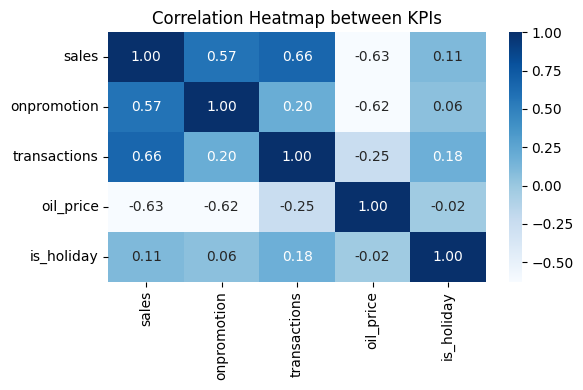

In [40]:
# =========================================================
# 📊 Cell 8 — Visual EDA: KPI Trends & Correlation Heatmap
# =========================================================

# Exclude non-numeric fields for visuals
exclude_cols = {"date", "store_nbr", "state", "type", "cluster"}
numeric_cols = [c for c in df_raw.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_raw[c])]

# --- Plot KPI Time Series (Plotly) ---
if "date" in df_raw.columns and numeric_cols:
    top_kpis = numeric_cols[:4]  # limit to 4 KPIs to avoid clutter
    fig = px.line(
        df_raw.sort_values("date"),
        x="date",
        y=top_kpis,
        title=f"KPI Overview ({', '.join(top_kpis)})",
        labels={"value": "Metric Value", "date": "Date"},
    )
    fig.update_layout(legend_title_text="KPIs")
    fig.show()
else:
    print("⚠️ Skipping time series plot (need 'date' + numeric columns).")

# --- Correlation Heatmap (Seaborn) ---
if len(numeric_cols) >= 2:
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_raw[numeric_cols].corr(), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Correlation Heatmap between KPIs")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough numeric columns for correlation heatmap.")

In [41]:
# =========================================================
# 🧱 Cell 9 — Feature Engineering (time, lags, rolling)
# =========================================================

# We will:
# 1) Add basic time features (day-of-week, month, weekend flag).
# 2) Add lag features to capture short/medium-term memory.
# 3) Add rolling statistics to model local trends and volatility.
# 4) Drop NA rows created by lagging/rolling.

def add_time_features(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    """
    Add calendar-based features: day-of-week, month, weekend flag.
    """
    out = df.copy()
    # Ensure datetime
    d = pd.to_datetime(out[date_col], errors="coerce")
    out["dow"] = d.dt.dayofweek          # 0=Mon ... 6=Sun
    out["month"] = d.dt.month
    out["is_weekend"] = (out["dow"] >= 5).astype(int)
    return out

def add_lag_roll(df: pd.DataFrame, target: str = "sales") -> pd.DataFrame:
    """
    Add lag and rolling-window features for the target column.
    - Lags: 7, 28 days
    - Rolling mean/std: 7 days
    - Percent change: 1, 7 days
    """
    out = df.copy()
    if target not in out.columns:
        raise KeyError(f"Target column '{target}' not found in DataFrame.")

    # Lags capture prior levels
    out[f"{target}_lag_7"] = out[target].shift(7)
    out[f"{target}_lag_28"] = out[target].shift(28)

    # Rolling stats capture local trend/volatility
    out[f"{target}_rollmean_7"] = out[target].rolling(7).mean()
    out[f"{target}_rollstd_7"]  = out[target].rolling(7).std()

    # Short & medium-term momentum
    out[f"{target}_pct_change_1"] = out[target].pct_change(1)
    out[f"{target}_pct_change_7"] = out[target].pct_change(7)

    return out

# ---- Build features pipeline ----
df_feat = add_lag_roll(add_time_features(df_raw), target="sales")

# Drop rows with NA introduced by lag/rolling windows
df_feat = df_feat.dropna().reset_index(drop=True)

print("✅ Feature engineering complete.")
print("Shape:", df_feat.shape)
display(df_feat.head())

✅ Feature engineering complete.
Shape: (1656, 15)


,date,sales,onpromotion,transactions,oil_price,is_holiday,dow,month,is_weekend,sales_lag_7,sales_lag_28,sales_rollmean_7,sales_rollstd_7,sales_pct_change_1,sales_pct_change_7
0,2013-01-29,264488.818076,0,68435.0,97.62,0,1,1,0,296214.728983,2511.618999,316383.951885,73839.837696,-0.073465,-0.107104
1,2013-01-30,281061.127052,0,70888.0,97.98,0,2,1,0,283258.453032,496092.417944,316070.048174,74008.606838,0.062658,-0.007757
2,2013-01-31,271254.217996,0,70268.0,97.65,0,3,1,0,247245.690995,361461.231124,319499.837745,70773.071168,-0.034892,0.097104
3,2013-02-01,369402.055266,0,78302.0,97.46,0,4,2,0,290022.771930,354459.677093,330839.735365,71617.207631,0.361830,0.273700
4,2013-02-02,518887.462705,0,97347.0,97.46,0,5,2,1,413799.767975,477350.121229,345852.263183,98044.288785,0.404669,0.253958


In [42]:
# =========================================================
# 🚨 Cell 10 — Anomaly Detection (Z-score, IQR, IsolationForest)
# =========================================================

# --- Z-score method ---
def zscore_flags(series: pd.Series, threshold: float = 3.0):
    """
    Calculate Z-scores and flag anomalies where |Z| >= threshold.
    """
    z = (series - series.mean()) / series.std(ddof=0)
    return z, (z.abs() >= threshold)

# --- IQR method ---
def iqr_flags(series: pd.Series, k: float = 1.5):
    """
    Flag values outside the IQR range [Q1 - k*IQR, Q3 + k*IQR].
    """
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k * iqr, q3 + k * iqr
    mask = (series < lo) | (series > hi)
    return mask, (lo, hi)

# --- Isolation Forest ---
# Select numeric features for model input
feature_cols = [
    "sales", "sales_lag_7", "sales_lag_28", "sales_rollmean_7", "sales_rollstd_7",
    "sales_pct_change_1", "sales_pct_change_7", "dow", "month", "is_weekend",
    "onpromotion", "transactions", "oil_price"
]
feature_cols = [c for c in feature_cols if c in df_feat.columns]

X = df_feat[feature_cols].fillna(0).to_numpy()

# Train Isolation Forest
iforest = IsolationForest(
    n_estimators=CFG["models"]["ml"]["n_estimators"],
    contamination=CFG["models"]["ml"]["contamination"],
    random_state=CFG["models"]["ml"]["random_state"]
)
iforest.fit(X)

# Get anomaly scores and flags
decision_scores = iforest.decision_function(X)   # higher = more normal
anomaly_flags = (iforest.predict(X) == -1).astype(int)

# --- Combine all results ---
z, zmask = zscore_flags(df_feat["sales"], 3.0)
imask, _ = iqr_flags(df_feat["sales"], 1.5)

df_det = df_feat[["date", "sales"]].copy()
df_det["zscore"] = z
df_det["anom_zscore"] = zmask.astype(int)
df_det["anom_iqr"] = imask.astype(int)
df_det["iforest_score"] = decision_scores
df_det["anom_iforest"] = anomaly_flags

# Combined anomaly flag
df_det["anom_any"] = df_det[["anom_zscore", "anom_iqr", "anom_iforest"]].max(axis=1)

print("✅ Anomaly detection complete.")
print("Total anomalies detected:", int(df_det["anom_any"].sum()))
display(df_det.head())

✅ Anomaly detection complete.
Total anomalies detected: 35


,date,sales,zscore,anom_zscore,anom_iqr,iforest_score,anom_iforest,anom_any
0,2013-01-29,264488.818076,-1.624939,0,0,0.063405,0,0
1,2013-01-30,281061.127052,-1.553718,0,0,0.099792,0,0
2,2013-01-31,271254.217996,-1.595864,0,0,0.089408,0,0
3,2013-02-01,369402.055266,-1.174064,0,0,0.086678,0,0
4,2013-02-02,518887.462705,-0.531637,0,0,0.063078,0,0


In [43]:
# =========================================================
# 📈 Cell 11 — Visualize Anomalies on the Time Series (Plotly)
# =========================================================

# We will:
# 1) Define a helper that plots the KPI line.
# 2) Overlay anomaly points from any chosen flag column (e.g., 'anom_iforest').
# 3) Show an interactive Plotly chart.

def plot_anomalies(
    df: pd.DataFrame,
    date_col: str = "date",
    value_col: str = "sales",
    flag_col: str = "anom_iforest",
    title: str | None = None,
):
    """
    Plot a time series with anomaly markers.
    - df: DataFrame containing date, value, and a binary anomaly flag column.
    - date_col: name of the datetime column.
    - value_col: KPI to plot (e.g., 'sales').
    - flag_col: anomaly flag column (e.g., 'anom_iforest', 'anom_zscore', 'anom_iqr').
    """
    # Defensive checks
    if date_col not in df.columns or value_col not in df.columns:
        raise KeyError(f"Required columns missing: '{date_col}' or '{value_col}'")
    if flag_col not in df.columns:
        print(f"⚠️ Flag column '{flag_col}' not found. Plotting series without markers.")
    
    # Sort by date for a clean line
    df_plot = df.sort_values(date_col).copy()
    df_plot = df_plot.reset_index(drop=True)

    # Base line trace
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_plot[date_col],
        y=df_plot[value_col],
        mode="lines",
        name=value_col
    ))

    # Add anomaly markers if flag exists
    if flag_col in df_plot.columns:
        mask = df_plot[flag_col] == 1
        fig.add_trace(go.Scatter(
            x=df_plot.loc[mask, date_col],
            y=df_plot.loc[mask, value_col],
            mode="markers",
            name=f"Anomaly ({flag_col})",
            marker=dict(size=8, symbol="circle-open")
        ))

    fig.update_layout(
        title=title or f"{value_col} with anomalies ({flag_col})",
        xaxis_title=date_col,
        yaxis_title=value_col,
        legend_title_text="Legend"
    )
    fig.show()

# ---- Call the plotter (change flag_col to 'anom_zscore' or 'anom_iqr' if you want) ----
plot_anomalies(
    df=df_det,
    date_col="date",
    value_col="sales",
    flag_col="anom_iforest",
    title="Sales — Anomaly Visualization (IsolationForest)"
)

In [44]:
# =========================================================
# 🤖 Cell 10B — One-Class SVM (2nd ML model for comparison)
# =========================================================

# OCSVM works best with scaled features, so we'll use a Pipeline with StandardScaler.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Reuse the same feature set used for IsolationForest
ocsvm_features = feature_cols  # from Cell 10
if not ocsvm_features:
    raise ValueError("No numeric features available for One-Class SVM.")

X_ocsvm = df_feat[ocsvm_features].fillna(0).to_numpy()

# Defensive check for NaN/Inf
if np.isnan(X_ocsvm).any() or np.isinf(X_ocsvm).any():
    raise ValueError("Feature matrix for OCSVM contains NaN/Inf. Check preprocessing.")

# nu ~ expected fraction of anomalies (similar idea to 'contamination')
nu_val = float(CFG["models"]["ml"]["contamination"])
ocsvm = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", OneClassSVM(kernel="rbf", gamma="scale", nu=nu_val))
])

# Fit and infer
ocsvm.fit(X_ocsvm)
# decision_function: larger values => more normal; negatives => more anomalous
ocsvm_scores = ocsvm.named_steps["model"].decision_function(ocsvm.named_steps["scaler"].transform(X_ocsvm))
ocsvm_flags = (ocsvm.named_steps["model"].predict(ocsvm.named_steps["scaler"].transform(X_ocsvm)) == -1).astype(int)

# Append to detection table
df_det["ocsvm_score"] = ocsvm_scores
df_det["anom_ocsvm"] = ocsvm_flags

print("✅ One-Class SVM done.")
print("OCSVM anomalies:", int(df_det["anom_ocsvm"].sum()))
display(df_det.head())

✅ One-Class SVM done.
OCSVM anomalies: 40


,date,sales,zscore,anom_zscore,anom_iqr,iforest_score,anom_iforest,anom_any,ocsvm_score,anom_ocsvm
0,2013-01-29,264488.818076,-1.624939,0,0,0.063405,0,0,-0.000112,1
1,2013-01-30,281061.127052,-1.553718,0,0,0.099792,0,0,0.197605,0
2,2013-01-31,271254.217996,-1.595864,0,0,0.089408,0,0,0.201411,0
3,2013-02-01,369402.055266,-1.174064,0,0,0.086678,0,0,0.293373,0
4,2013-02-02,518887.462705,-0.531637,0,0,0.063078,0,0,0.069632,0


In [45]:
# =========================================================
# 🧠 Cell 10C — Local Outlier Factor (3rd ML model)
# =========================================================

from sklearn.neighbors import LocalOutlierFactor

# LOF expects unscaled numeric features; use same set as IsolationForest
lof_features = feature_cols
X_lof = df_feat[lof_features].fillna(0).to_numpy()

# Defensive checks
if np.isnan(X_lof).any() or np.isinf(X_lof).any():
    raise ValueError("Feature matrix for LOF contains NaN/Inf. Check preprocessing.")

# n_neighbors controls local density comparison; contamination ~ expected anomaly fraction
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=CFG["models"]["ml"]["contamination"],
    novelty=False  # True = can predict on new data, False = fit_predict at once
)

# LOF uses fit_predict instead of separate fit/predict
lof_flags = (lof.fit_predict(X_lof) == -1).astype(int)
lof_scores = -lof.negative_outlier_factor_  # higher = more abnormal

# Append to detection table
df_det["lof_score"] = lof_scores
df_det["anom_lof"] = lof_flags

print("✅ Local Outlier Factor done.")
print("LOF anomalies:", int(df_det["anom_lof"].sum()))
display(df_det.head())

✅ Local Outlier Factor done.
LOF anomalies: 34


,date,sales,zscore,anom_zscore,anom_iqr,iforest_score,anom_iforest,anom_any,ocsvm_score,anom_ocsvm,lof_score,anom_lof
0,2013-01-29,264488.818076,-1.624939,0,0,0.063405,0,0,-0.000112,1,5.704651,1
1,2013-01-30,281061.127052,-1.553718,0,0,0.099792,0,0,0.197605,0,1.661749,0
2,2013-01-31,271254.217996,-1.595864,0,0,0.089408,0,0,0.201411,0,1.813290,1
3,2013-02-01,369402.055266,-1.174064,0,0,0.086678,0,0,0.293373,0,1.392253,0
4,2013-02-02,518887.462705,-0.531637,0,0,0.063078,0,0,0.069632,0,1.029860,0


🔢 Anomaly counts by detector:
 anom_ocsvm      40
anom_iforest    34
anom_lof        34
anom_iqr         5
anom_zscore      4
dtype: int64


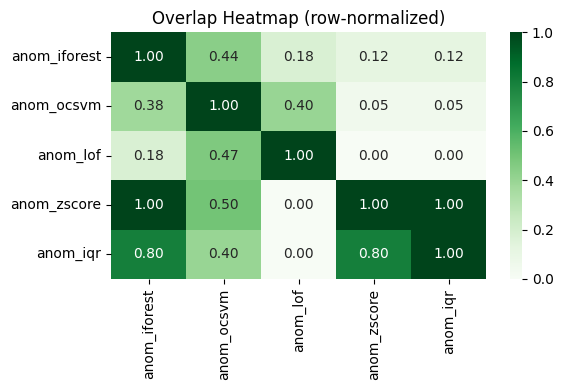

🧮 Top anomalies by model agreement (vote_sum):


,date,sales,vote_sum,anom_iforest,anom_ocsvm,anom_lof,anom_zscore,anom_iqr
1430,2017-01-02,1.402306e+06,4,1,1,0,1,1
1519,2017-04-01,1.463084e+06,4,1,1,0,1,1
336,2014-01-01,8.602065e+03,3,1,1,1,0,0
1064,2016-01-01,1.643339e+04,3,1,1,1,0,0
1067,2016-01-04,9.559569e+05,3,1,1,1,0,0
1172,2016-04-18,1.345921e+06,3,1,0,0,1,1
1429,2017-01-01,1.208250e+04,3,1,1,1,0,0
1436,2017-01-08,1.192544e+06,3,1,1,1,0,0
1583,2017-06-04,1.376512e+06,3,1,0,0,1,1
0,2013-01-29,2.644888e+05,2,0,1,1,0,0


✅ Consensus rule applied: vote_sum >= 2
Consensus anomalies: 29


In [46]:
# =========================================================
# 📊 Cell 10D — Compare Models (counts, overlaps, top anomalies)
# =========================================================

# 1) Collect all available anomaly flag columns
flag_cols = [c for c in [
    "anom_iforest", "anom_ocsvm", "anom_lof",  # ML models
    "anom_zscore", "anom_iqr"                  # statistical baselines
] if c in df_det.columns]

if not flag_cols:
    raise ValueError("No anomaly flag columns found. Run the detector cells first.")

# 2) Basic counts per detector (how many anomalies each found)
counts = df_det[flag_cols].sum().sort_values(ascending=False)
print("🔢 Anomaly counts by detector:\n", counts)

# Bar chart of anomaly counts
fig = go.Figure()
fig.add_trace(go.Bar(x=counts.index, y=counts.values, name="Anomaly count"))
fig.update_layout(
    title="Anomaly Counts by Detector",
    xaxis_title="Detector",
    yaxis_title="# anomalies",
    bargap=0.25
)
fig.show()

# 3) Overlap matrix (pairwise % overlap) — proportion of rows both detectors flag as anomalies
import itertools
overlap = pd.DataFrame(index=flag_cols, columns=flag_cols, dtype=float)
for a, b in itertools.product(flag_cols, flag_cols):
    both = ((df_det[a] == 1) & (df_det[b] == 1)).sum()
    denom = max(1, (df_det[a] == 1).sum())  # normalize by anomalies in 'a'
    overlap.loc[a, b] = both / denom

# Heatmap for overlap (rows normalized)
plt.figure(figsize=(6, 4))
sns.heatmap(overlap.astype(float), annot=True, fmt=".2f", cmap="Greens")
plt.title("Overlap Heatmap (row-normalized)")
plt.tight_layout()
plt.show()

# 4) Simple voting ensemble (sum of flags) and top anomalies table
df_det["vote_sum"] = df_det[flag_cols].sum(axis=1)
top_anoms = (df_det[df_det["vote_sum"] > 0]
             .sort_values(["vote_sum", "date"], ascending=[False, True])
             .loc[:, ["date", "sales", "vote_sum"] + flag_cols]
             .head(20))

print("🧮 Top anomalies by model agreement (vote_sum):")
display(top_anoms)

# 5) Optional: plot with a chosen consensus rule (e.g., vote_sum >= 2)
CONSENSUS_K = 2  # change to 1 (any), 2 (at least two), 3 (strict), etc.
df_det["anom_consensus"] = (df_det["vote_sum"] >= CONSENSUS_K).astype(int)

print(f"✅ Consensus rule applied: vote_sum >= {CONSENSUS_K}")
print("Consensus anomalies:", int(df_det["anom_consensus"].sum()))

# Visualize consensus anomalies on the series
plot_anomalies(
    df=df_det.rename(columns={"anom_consensus": "anom_temp_consensus"}),
    date_col="date",
    value_col="sales",
    flag_col="anom_temp_consensus",
    title=f"Sales — Consensus Anomalies (vote_sum ≥ {CONSENSUS_K})"
)
# Clean up temp column to keep df_det tidy
df_det.drop(columns=["anom_temp_consensus"], errors="ignore", inplace=True)

In [47]:
half = len(df_feat) // 2
df_a, df_b = df_feat.iloc[:half], df_feat.iloc[half:]

model_a = IsolationForest(random_state=42).fit(df_a[feature_cols])
model_b = IsolationForest(random_state=42).fit(df_b[feature_cols])

pred_a = model_a.predict(df_a[feature_cols])
pred_b = model_b.predict(df_b[feature_cols])
print("Stability (same predictions ratio):", (pred_a.mean() == pred_b.mean()))

Stability (same predictions ratio): False


In [48]:
# Evaluate how similar the anomaly flags are between model A and model B
from sklearn.metrics import accuracy_score

pred_a = (model_a.predict(df_a[feature_cols]) == -1).astype(int)
pred_b = (model_b.predict(df_b[feature_cols]) == -1).astype(int)

# Compare the *rate* of anomalies rather than exact matches
print("Anomaly rate A:", pred_a.mean())
print("Anomaly rate B:", pred_b.mean())

# If you really want to measure overlap (requires same length & window)
min_len = min(len(pred_a), len(pred_b))
agreement = (pred_a[:min_len] == pred_b[:min_len]).mean()
print(f"Stability agreement: {agreement:.2f}")

Anomaly rate A: 0.14009661835748793
Anomaly rate B: 0.11956521739130435
Stability agreement: 0.78


In [49]:
# =========================================================
# 🧾 Final Save + Verify (robust to working directory)
# =========================================================
from pathlib import Path
import pandas as pd

# 1) Locate the project root by searching upwards for a "data" folder
cwd = Path.cwd()
candidates = [cwd, cwd.parent, cwd.parent.parent]
data_dir = None
for base in candidates:
    if (base / "data").exists():
        data_dir = base / "data"
        break

if data_dir is None:
    # Fallback: create alongside current cwd
    data_dir = cwd / "data"
    (data_dir / "processed").mkdir(parents=True, exist_ok=True)

processed_dir = data_dir / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

print("📂 CWD:", cwd)
print("📁 Using processed dir:", processed_dir)

# 2) Define file paths
clean_fp = processed_dir / "clean_data.csv"
anom_fp  = processed_dir / "anomalies.csv"

# 3) Save (re-save to be 100% sure)
#    Requires df_feat and df_det to exist from previous cells.
df_feat.to_csv(clean_fp, index=False)
df_det[df_det["anom_any"] == 1].to_csv(anom_fp, index=False)

# 4) Verify and quick summaries
print("\n🔍 Verifying...")
assert clean_fp.exists(), f"❌ Missing {clean_fp}"
assert anom_fp.exists(),  f"❌ Missing {anom_fp}"
print("✅ Both processed files saved.")

df_clean = pd.read_csv(clean_fp, parse_dates=["date"])
df_anom  = pd.read_csv(anom_fp,  parse_dates=["date"])

print(f"\n✅ Clean data loaded: {df_clean.shape}")
print(f"✅ Anomalies loaded: {df_anom.shape}")
print(f"Anomaly ratio: {len(df_anom) / max(1, len(df_clean)):.2%}")



📂 CWD: /Users/dhwanil/Desktop/ONGOING PROJECTS/kpi anomaly detector/notebook
📁 Using processed dir: /Users/dhwanil/Desktop/ONGOING PROJECTS/kpi anomaly detector/data/processed

🔍 Verifying...
✅ Both processed files saved.

✅ Clean data loaded: (1656, 15)
✅ Anomalies loaded: (35, 14)
Anomaly ratio: 2.11%
